In [248]:
from astropy.coordinates import EarthLocation,SkyCoord,CartesianRepresentation
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
from astropy.coordinates import AltAz
from astropy.time import Time, TimeDelta
from astropy import units as u
import numpy as np
dt = TimeDelta(1, format='jd')
t=Time('2023-12-28T00:00:00',format="isot",scale="utc")+ dt * np.linspace(0, 0.25, 5)
breakout=lambda la,lo,ht:{'lat':la,'lon':lo,'height':ht*u.m}
print(f"Times: {t}") 
def xyz2uvwMAT(Ra,Dec):
    sinH,cosH=(np.sin(Ra),np.cos(Ra))
    sinI,cosI=(np.sin(Dec),np.cos(Dec))
    return np.array([[ sinH     ,cosH     ,0],
                     [-sinI*cosH,sinI*sinH,cosI],
                     [cosI*cosH,-cosI*sinH,sinI]])

earthSpots={"Bunker Hill Monument":[42.37630000,-71.06070000,30.0,1531609,-4463479,4276597,844.3,932.3,20.0],
            "Old South Church":[42.35020000,-71.07800000,20.0,1530895,-4465783,4274447,-579.0,-1968.4,10.0],
            "Old North Church":[42.36640000,-71.05440000,20.0,1532341,-4464003,4275779,1366.7,-166.4,10.0],
            "USS Constitution":[42.37250000,-71.05660000,5.0,1532016,-4463622,4276267,1182.5,508.9,-5.0]
            }# "Museum of Science":[42.36790000,-71.07100000,10.0,1531010,-4464333,4275895,0.0,0.0,0.0],
            # "Kendall Square":[42.36570000,-71.08230000,7.0,1530181,-4464795,4275706,-934.4,-252.6,-3.0],
            # "Hatch Shell":[42.35790000,-71.07390000,4.0,1531021,-4465118,4275068,-244.4,-1113.7,-6.0],
            # "Frog Pond":[42.35620000,-71.06580000,15.0,1531700,-4465028,4274936,427.7,-1302.1,5.0],
            # "Public Garden":[42.35400000,-71.07000000,8.0,1531421,-4465292,4274751,77.8,-1545.9,-2.0],
            # "Public Library":[42.34950000,-71.07820000,20.0,1530898,-4465841,4274385,-594.8,-2052.0,10.0],
            # "MIT Dome":[42.35990000,-71.09200000,40.0,1529573,-4465489,4275251,-1733.5,-898.5,30.0]}
             
print (f"Location Baselines:{len(earthSpots)*(len(earthSpots)-1)/2}")

observingFrequency=1.42e9     #Hz
c=299792458                   #m/s
observingWavelength=c/observingFrequency
print(f"Observing Freq and wavelength: {observingFrequency/1e6} MHz   {observingWavelength*100:5.4} cm")
#phase reference position (RA, DEC Degrees)
Ho=82.9106369047619
Io=1.077503968253968
HoRAD,IoRAD = np.array([Ho,Io])*np.pi/180.0
phaseRefLoc=SkyCoord(HoRAD,IoRAD,unit="rad",frame="icrs").transform_to("galactic")
rotMAT=xyz2uvwMAT(HoRAD,IoRAD)
print(f"Phase Ref Position: Ho={Ho:5.4f}    Io={Io:5.4f} (degrees)")
print(f"                    Ho={HoRAD:5.4f}     Io={IoRAD:5.4f} (radians)")
baselines=[{"P1":(a,EarthLocation(**breakout(*(earthSpots[a][:3])))),
            "P2":(b,EarthLocation(**breakout(*(earthSpots[b][:3]))))}
            for i,a in enumerate(earthSpots.keys()) for j,b in enumerate(earthSpots.keys()) if j>i]
meanXYZbaseline=np.zeros((len(t),len(baselines)))
meanUVWbaseline=np.zeros((len(t),len(baselines)))
baselineCount=len(baselines)
for i,bl in enumerate(baselines):
    #center of baseline in XYZ wavelengths for the two points
    baselines[i]["BL"]= EarthLocation.from_geocentric(**dict((ff,(x1.value+x2.value)/2/observingWavelength) 
                                                         for x1,x2,ff in zip(baselines[i]["P1"][1].to_geocentric() , 
                                                                             baselines[i]["P2"][1].to_geocentric(),['x','y','z'])),
                                                                             unit=observingWavelength*u.m)

    baselines[i]["D"]=np.array([x2.value-x1.value for x1,x2 in zip(baselines[i]["P1"][1].to_geocentric() ,baselines[i]["P2"][1].to_geocentric())]+[0.,0.,0.,0.]);
    baselines[i]["D"][3]=np.sqrt(np.sum([xx**2 for xx in baselines[i]["D"]]))

    baselines[i]["XYZvT"]=baselines[i]["BL"].get_gcrs_posvel(t)

meanXYZbaseline=(lambda x,lll : EarthLocation.from_geocentric(x=x[:,0],
                                              y=x[:,1],
                                              z=x[:,2],
                                              unit=lll)) (np.array([[[x.x.value,
                                                                      x.y.value,
                                                                      x.z.value] for x in baselines[j]["BL"].get_gcrs_posvel(t)[0]] 
                                                                      for j in range(len(baselines))]).mean(axis=0),observingWavelength*u.m)

for i,bl in enumerate(baselines):
    baselines[i]["XYZvTrel"] = np.array([[X.x.value-meanX.x.value,X.y.value-meanX.y.value,X.z.value-meanX.z.value] for X,meanX in zip(baselines[i]["XYZvT"][0],meanXYZbaseline)])
    baselines[i]["AzEl"]=[(ipoint.az.value,ipoint.alt.value) for ipoint in phaseRefLoc.transform_to(AltAz(location=baselines[i]["BL"], obstime=t))]
    baselines[i]["UVWvT"]=np.transpose(rotMAT.dot(np.transpose(np.array([[pp.x.value,
                                                                          pp.y.value,
                                                                          pp.z.value] for pp in baselines[i]["XYZvT"]]))))

meanUVWbaseline=EarthLocation.from_geocentric(x=meanUVWbaseline[0],y=meanUVWbaseline[1],z=meanUVWbaseline[2],unit=observingWavelength*u.m)

print(f"Baselines: ({baselineCount} total) (meanXYZbaseline={meanXYZbaseline}\n" + '\t'*3 + f" meanUVWbaseline={meanUVWbaseline})")
#print(baselines)
for i,bl in enumerate(baselines):
    print(f"{i:4d} #####################\t{str(bl['P1'][0])}->{str(bl['P2'][0])}" +
          f"\n\tDxyz--> {bl['D'][:4]}" +
          f"\n\tXYZ--> {bl['XYZvT'][0]}\n\tUVW--> {bl['UVWvT']}" +
          f"\n\tAzEl--> {bl['AzEl']}")
        #   f"\n\t\t\t{str(c[:2])}"+
        #   f"\n\t\t\t\t{str(c[-1])}")
# for i,bl in enumerate(baselines):
#     print(f"{i:4d} #####################\n\t{str(a)} \n\t\t--> {str(b)}"+
#           f"\n\t\t\t{str(c[:2])}"+
#           f"\n\t\t\t\t{str(c[-1])}")
#XYZp,XYZv=observing_location.get_gcrs_posvel(t[0] + dt * np.linspace(0., 1., 13))
#XYZp



Times: ['2023-12-28T00:00:00.000' '2023-12-28T01:30:00.000'
 '2023-12-28T03:00:00.000' '2023-12-28T04:30:00.000'
 '2023-12-28T06:00:00.000']
Location Baselines:6.0
Observing Freq and wavelength: 1420.0 MHz   21.11 cm
Phase Ref Position: Ho=82.9106    Io=1.0775 (degrees)
                    Ho=1.4471     Io=0.0188 (radians)


AttributeError: 'numpy.ndarray' object has no attribute 'x'

In [178]:
print(i)
baselines[i]["P1"][1].to_geocentric()
dd=np.array([x2.value-x1.value for x1,x2 in zip(baselines[i]["P1"][1].to_geocentric() ,baselines[i]["P2"][1].to_geocentric())]+[0.,0.,0.,0.])
dd[-1]=np.sqrt(np.sum([xx**2 for xx in dd]))
dd[3:6]=rotMAT @ dd[0:3]
print(np.sqrt(np.sum([xx**2 for xx in dd[3:6]])))
dd

2
2649.232571410716


array([ 1445.67191985,  1777.7133036 ,  1329.73731533,  1654.02005189,
        1359.32111503, -1560.41564707,  2649.23257141])

In [251]:
rotMAT @ np.transpose(baselines[i]["XYZvTrel"])

array([[ 1888.3770335 ,  2600.01479466,  2913.26317039,  2780.17483005,
         2221.1209176 ],
       [-1232.08271051, -1216.63873159, -1196.37975815, -1174.4066999 ,
        -1154.08283014],
       [ 2208.93251068,  1312.66588562,   212.01801168,  -924.5405781 ,
        -1923.04268115]])

In [236]:
kkk=np.array([[[x.x.value,x.y.value,x.z.value] for x in baselines[j]["BL"].get_gcrs_posvel(t)[0]] for j in range(len(baselines))]).mean(axis=0)
print(EarthLocation.from_geocentric(x=kk[:,0],y=kk[:,1],z=kk[:,2],unit=observingWavelength*u.m))
(lambda x,lll : EarthLocation.from_geocentric(x=x[:,0],
                                              y=x[:,1],
                                              z=x[:,2],
                                              unit=lll)) (np.array([[[x.x.value,
                                                                      x.y.value,
                                                                      x.z.value] for x in baselines[j]["BL"].get_gcrs_posvel(t)[0]] 
                                                                      for j in range(len(baselines))]).mean(axis=0),observingWavelength*u.m)
#EarthLocation.from_geocentric(x=kk[0].x.value,kk[0].y.value,kk[0].z.value,unit=observingWavelength*u.m)

[(20333967.0488848 ,  9391883.44087659, 20205262.33751393)
 (15178167.44590676, 16456808.92947658, 20216997.53876969)
 ( 7706315.37823333, 21002873.88233608, 20234186.63089259)
 ( -937910.92561406, 22334235.45422314, 20254198.73534471)
 (-9431383.91858025, 20247108.98067215, 20273970.79866285)] 0.211121 m


<EarthLocation [(20333967.0488848 ,  9391883.44087659, 20205262.33751393),
                (15178167.44590676, 16456808.92947658, 20216997.53876969),
                ( 7706315.37823333, 21002873.88233608, 20234186.63089259),
                ( -937910.92561406, 22334235.45422314, 20254198.73534471),
                (-9431383.91858025, 20247108.98067215, 20273970.79866285)] 0.211121 m>

In [224]:
print(t)
hh=np.array([[[x.x.value,x.y.value,x.z.value] for x in baselines[j]["BL"].get_gcrs_posvel(t)[0]] for j in range(len(baselines))])
print(hh)
hh.mean(axis=0)
print(np.array([[[x.x.value,x.y.value,x.z.value] for x in baselines[j]["BL"].get_gcrs_posvel(t)[0]] for j in range(len(baselines))]).mean(axis=0))

['2023-12-28T00:00:00.000' '2023-12-28T01:30:00.000'
 '2023-12-28T03:00:00.000' '2023-12-28T04:30:00.000'
 '2023-12-28T06:00:00.000']
[[[20336116.42066799  9389901.84982033 20204072.01138791]
  [15180912.38384121 16455804.71227196 20215805.79970224]
  [ 7709235.30778727 21003000.74357742 20232994.44966124]
  [ -935263.36404946 22335473.97011966 20253007.15043433]
  [-9429414.39464731 20249269.572148   20272780.75731273]]

 [[20331583.78908942  9392874.61416668 20207231.66249878]
  [15175586.66675653 16456808.09942158 20218967.35371735]
  [ 7703932.80373919 21001881.18557838 20236156.01774295]
  [ -939729.90960203 22332402.84736293 20256166.84153765]
  [-9432360.19211303 20244716.98104934 20275936.96763648]]

 [[20330761.66299638  9392019.75356548 20208395.26769532]
  [15175155.66956008 16455702.20087883 20220130.05954581]
  [ 7703959.31848858 21000693.5289916  20237317.66476924]
  [ -939249.52886111 22331315.22691623 20257327.4323878 ]
  [-9431499.06227087 20243895.87890913 20277096.66

In [219]:
baselines[1]["BL"].get_gcrs_posvel(t)[0]

<CartesianRepresentation (x, y, z) in 0.211121 m
    [(20331583.78908942,  9392874.61416668, 20207231.66249878),
     (15175586.66675653, 16456808.09942158, 20218967.35371735),
     ( 7703932.80373919, 21001881.18557838, 20236156.01774295),
     ( -939729.90960203, 22332402.84736293, 20256166.84153765),
     (-9432360.19211303, 20244716.98104934, 20275936.96763648)]>

In [60]:
# Bunker Hill Monument: 42.37633621914482, -71.06072544082996
observing_location = EarthLocation(**breakout(*(earthSpots['Bunker Hill Monument'][:3])))  
#observing_location = EarthLocation(lat='42.37633621914482', lon='-71.06072544082996', height=30*u.m)  
observing_time = t[0]  
aa = AltAz(location=observing_location, obstime=observing_time)

#Rigel and Betelgeuse
coords = ["05:14:33.700000	-8.200806", "05:55:11.700000	7.407667"]
c = SkyCoord(coords, unit=(u.hourangle, u.deg))
#print(c)
#coord = SkyCoord('4h42m', '-38d6m50.8s')
print(f"SkyCoord original: {c}")
print(f"Transformed to AA:{c.transform_to(aa)}")


SkyCoord original: <SkyCoord (ICRS): (ra, dec) in deg
    [(78.64041667, -8.200806), (88.79875   ,  7.407667)]>
Transformed to AA:<SkyCoord (AltAz: obstime=2023-10-01T11:00:00.000, location=(1531612.29777372, -4463480.79182169, 4276594.14281663) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    [(210.44824942, 34.56128858), (204.60635023, 52.69407351)]>


In [61]:
XYZp,XYZv=observing_location.get_gcrs_posvel(Time.now())
print(f"   Position: {','.join([f'{int(xx.value)}' for xx in XYZp.xyz])} m\n   Velocity: {XYZv}")

   Position: -819434,4645631,4278363 m
   Velocity: (-338.75383024, -60.47792874, 0.7880451) m / s


In [62]:
XYZp.transform

<CartesianRepresentation (x, y, z) in m
    (-819434.58185238, 4645631.09883387, 4278363.37068726)>

In [112]:
XYZp,XYZv=observing_location.get_gcrs_posvel(Time('2023-10-01T17:00:00',format="isot",scale="utc") + dt * np.linspace(0., 1., 13))
XYZp

<CartesianRepresentation (x, y, z) in m
    [(-4572789.36164484, -1125968.34879062, 4287137.41365681),
     (-3391091.02296403, -3271276.8499555 , 4284507.42990888),
     (-1293244.73663035, -4535311.92940957, 4279745.11228876),
     ( 1155622.27611058, -4577562.17527132, 4274133.38099184),
     ( 3295823.26004819, -3386646.04968133, 4269184.00221044),
     ( 4550821.29017248, -1283377.90053092, 4266230.32915104),
     ( 4582539.38078458,  1165654.43420227, 4266068.10020767),
     ( 3382433.18942446,  3300719.60883963, 4268741.06206125),
     ( 1273792.72618119,  4546664.15871351, 4273529.17278264),
     (-1175346.95907428,  4567849.92114224, 4279142.5654846 ),
     (-3305225.60648325,  3358569.75005321, 4284069.02328865),
     (-4542086.92486029,  1244584.9332676 , 4286981.36022573),
     (-4552739.63574187, -1204629.84408784, 4287094.96278124)]>

In [108]:
import numpy as np
t=[Time('2023-10-01T17:00:00',format="isot",scale="utc")]
dt = TimeDelta(1, format='jd')
t[0] + dt * np.linspace(0., 1., 13)

<Time object: scale='utc' format='isot' value=['2023-10-01T17:00:00.000' '2023-10-01T19:00:00.000'
 '2023-10-01T21:00:00.000' '2023-10-01T23:00:00.000'
 '2023-10-02T01:00:00.000' '2023-10-02T03:00:00.000'
 '2023-10-02T05:00:00.000' '2023-10-02T07:00:00.000'
 '2023-10-02T09:00:00.000' '2023-10-02T11:00:00.000'
 '2023-10-02T13:00:00.000' '2023-10-02T15:00:00.000'
 '2023-10-02T17:00:00.000']>

In [222]:
np.linspace(0, 0.25, 5)

array([0.    , 0.0625, 0.125 , 0.1875, 0.25  ])

In [1]:
import matplotlib.pyplot as plt

from astropy.visualization import astropy_mpl_style

plt.style.use(astropy_mpl_style)

from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

image_file = get_pkg_data_filename('data/FITS-images/asagao.cont.clean.natural.pb.fits')
fits.info(image_file)

Filename: data\FITS-images\asagao.cont.clean.natural.pb.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      73   (6720, 6720, 1, 1)   float32   


(1, 1, 6720, 6720)


TypeError: Invalid shape (1, 1, 6720, 6720) for image data

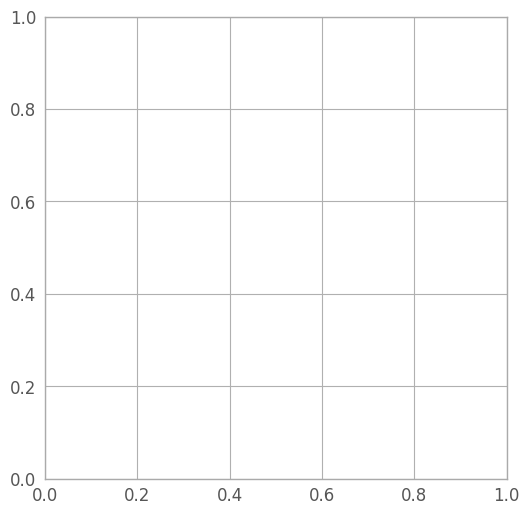

In [2]:
image_data = fits.getdata(image_file, ext=0)
print(image_data.shape)
plt.figure()
plt.imshow(image_data, cmap='gray')
plt.colorbar()

In [5]:
image_data.getfield()


TypeError: getfield() missing required argument 'dtype' (pos 1)